In [6]:
import sopy as sp
import pandas as pd
import sopy.tensorly as stl
import tensorflow as tf
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sopy.pyscf.ext import *

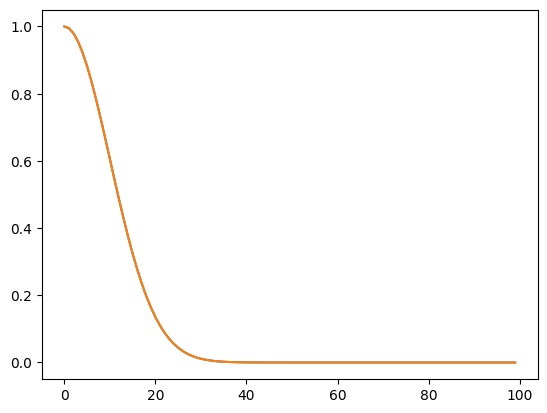

In [29]:
y = sp.Vector().gaussian( a=1, ls=[0], sigmas=[10], positions=[0], lattices=[range(100)])[1][0]
plt.plot(y/y[0])
plt.plot(list(map( lambda x :  np.exp( -0.5/100 * x**2 ) , range(100))))


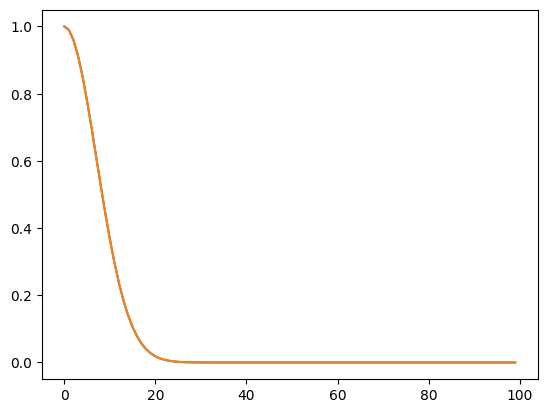

In [31]:
alpha = 0.01
y = sp.Vector().gaussian( a=1, ls=[0], sigmas=[np.sqrt(0.5/alpha)], positions=[0], lattices=[range(100)])[1][0]
plt.plot(y/y[0])
plt.plot(list(map( lambda x :  np.exp( -alpha* x**2 ) , range(100))))

In [43]:
def get_orbital(mol, orb, b, lattices, tolerance = 1e-9):
    """
    These dudes should be natively orthogonal
    """
    BA = tabulate(mol)
    orb1 = np.transpose(orb)[b]

    Sum = sp.Vector()
    BA1 = BA.set_index(['bb']).copy()
    BA1['coef'] *= pd.Series(orb1)
    BAG = BA1.groupby(['lx','ly','lz','exp','x','y','z'])['coef'].sum()    
    for lx,ly,lz,exp,x,y,z in BAG[BAG.abs()>tolerance].index:
            coef = BAG[lx,ly,lz,exp,x,y,z]
            positions = (x,y,z)
            ls        = (lx,ly,lz)
            sigmas    = np.sqrt(0.5*np.sqrt(0.5)/np.array([exp,exp,exp]))
            v = sp.Vector().gaussian(ls=ls,positions=positions, sigmas=sigmas, a = coef, lattices = lattices)
            Sum += v
    return Sum



In [44]:
DownSampling = 1
partition = 12
tol = 1e-12
# Vector
grid_points = 1024
# spatial setup
padding = 3

# compute extra
padding_factor = 1


atom_geometry = ''' He 0 0 0 '''
z_offset = 0.0


from pyscf import gto, scf

def get_molecular_orbital_image(atom_str, basis, padding=3.0, grid_points=100, canons = 4, z_offset = 0.0):
    """
    Calculates the HOMO orbital and slices it into a 2D image.
    """
    # 1. Build Molecule & Run SCF
    mol = gto.M(atom=atom_str, basis=basis, verbose=0)
    mf = scf.RHF(mol).run()
    
    # 2. Define the 2D Grid (Slice at Z=0)
    # We define a square window around the molecule
    L = np.max(np.abs(mol.atom_coords())) + padding
    x = np.linspace(-L, L, grid_points)
    y = np.linspace(-L, L, grid_points)
    X, Y = np.meshgrid(x, y)
    
    coords = np.vstack([X.flatten(), Y.flatten(), np.full_like(X.flatten(), z_offset)]).T

    # 3. Evaluate Orbitals on Grid
    # 'GTOval' calculates the value of the Atomic Orbitals (AO) at these points
    ao_value = mol.eval_gto("GTOval", coords)
    
    # Transform AO to Molecular Orbitals (MO) using the calculated coefficients
    # shape: (num_points, num_orbitals)
    mo_value = ao_value @ mf.mo_coeff
    
    # 4. Extract HOMO (Highest Occupied Molecular Orbital)
    # For a neutral closed shell, HOMO is at index n_elec/2 - 1
    n_occ = mol.nelectron // 2
    homo_idx = n_occ - 1
    homo_flat = mo_value[:, homo_idx]
    lattices = (x,y,x)

    # Reshape back to 2D image
    orbital_image = homo_flat.reshape(grid_points, grid_points)

    lattices_dict= { d + 1 : lattices[d] for d in range(2)}
    
    s = get_orbital( mol, mf.mo_coeff, homo_idx, lattices  ) 

    s2 = sp.Vector().transpose( { 0 : (s[0] * s[3][:,grid_points//2]) , 1 : s[2][:,::DownSampling] , 2 : (s[1][:,::DownSampling])} 
                                , lattices_dict)
    norm = s2.n()
    s2 = s2.copy(True).fibonacci(partition)
    return np.array([x, y]), X, Y, orbital_image, norm, s2

# --- Run the Generator ---

lattices, X, Y, signal, norm, generate_signal = get_molecular_orbital_image(atom_geometry, 'sto-3g', padding=padding, grid_points=grid_points, z_offset = z_offset)

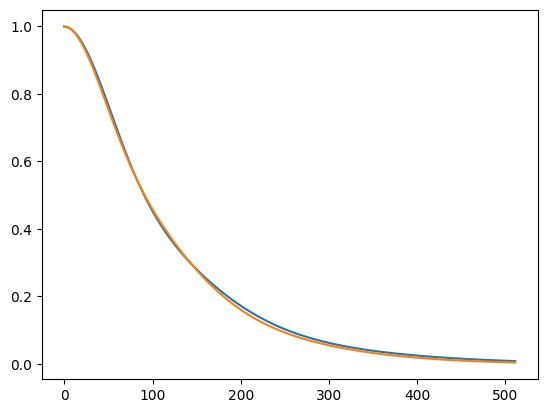

In [45]:
plt.plot(signal[grid_points//2,grid_points//2:])
plt.plot(stl.image(generate_signal)[grid_points//2,grid_points//2:]/stl.image(generate_signal)[grid_points//2,grid_points//2])